#### CEU ML course: Assignment 1
by Chiara Castelli 

In [732]:
# import packages

import os
import sys
import warnings
import plotnine as pn

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

from mizani.formatters import percent_format
from plotnine import *
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats import norm
from IPython.core.display import HTML
import statsmodels.nonparametric.kernel_regression as loess

warnings.filterwarnings("ignore")


In [733]:

# Define folders
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

# Import the prewritten helper functions
from py_helper_functions import *

In [734]:
# read database and variables contained
data = pd.read_csv("https://osf.io/4ay9x/download") 
# display basic info 
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149316 entries, 0 to 149315
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  149316 non-null  int64  
 1   hhid        149316 non-null  int64  
 2   intmonth    149316 non-null  object 
 3   stfips      149316 non-null  object 
 4   weight      149316 non-null  float64
 5   earnwke     149316 non-null  float64
 6   uhours      149316 non-null  int64  
 7   grade92     149316 non-null  int64  
 8   race        149316 non-null  int64  
 9   ethnic      20071 non-null   float64
 10  age         149316 non-null  int64  
 11  sex         149316 non-null  int64  
 12  marital     149316 non-null  int64  
 13  ownchild    149316 non-null  int64  
 14  chldpres    149316 non-null  int64  
 15  prcitshp    149316 non-null  object 
 16  state       149316 non-null  object 
 17  ind02       149316 non-null  object 
 18  occ2012     149316 non-null  int64  
 19  cl

# Database on occupations and earnings

Database: US household censuns for a sample of individuals aged 16+.

Important variables considered
- Demographics: sex, age, education, maritial status, ethnicity/race, US citizenship and place of birth 	
- Wage: weekly wage, number of hours worked per week
- Occupation, using census 2010 classification
- Job characteristics: industry, type of occupation (i.e. public or private sector), occupation being part of a worker union, working part-time (coded)
- Others: state of residence

For an overview of the database please refer to: http://data.nber.org/morg/docs/cpsx.pdf , while the whole occupational classification (census 2010) is available at: https://www.bls.gov/cps/cenocc2010.htm .

# Data Cleaning 
Occupation chosen: **Teachers** (in the entire schooling system, i.e. including university professors)

In [735]:
# get the industries where they work
data['occ2012'].value_counts()
data['lfsr94'].unique()
data['class'].unique()


array(['Private, For Profit', 'Government - Federal',
       'Government - Local', 'Government - State', 'Private, Nonprofit'],
      dtype=object)

In [736]:
# Occupation chosen: Teachers (in the entire schooling system, i.e. including professors at the university)
data_work = data[
    ((data['occ2012'] >= 2200) & (data['occ2012'] < 2340)) |
    ((data['occ2012'] == 2540) ) |(data['occ2012'] == 2550)
]
print(data_work['occ2012'].shape[0])
# almost 9k observations



8972


In [737]:
# Filter by Industry
data_work.groupby("ind02").size()

# we want to keep only teachers related to the standard schooling system  - ie. kindergarden, primary and secondary school, university

# let's filter accordingly:
# first take out any space in the string
data_work['ind02'] = data_work['ind02'].str.strip()
# then filter
data_work = data_work[data_work['ind02'].isin([
    "Colleges and universities, including junior colleges (6112, 6113)", 
    "Elementary and secondary schools (6111)",
    "Child day care services (6244)"
])]



In [738]:
# Missing values 

# first general check
print(data_work.isnull().sum())
# unioncov has lots of na - let's check
print(data_work.groupby(["unioncov"]).size())
# it looks like only No are reported, potentially bias. Do not consider this info



Unnamed: 0       0
hhid             0
intmonth         0
stfips           0
weight           0
earnwke          0
uhours           0
grade92          0
race             0
ethnic        8069
age              0
sex              0
marital          0
ownchild         0
chldpres         0
prcitshp         0
state            0
ind02            0
occ2012          0
class            0
unionmme         0
unioncov      3576
lfsr94           0
dtype: int64
unioncov
No     4808
Yes     357
dtype: int64


In [739]:
# Job Category: Private and Public jobs
data_work.groupby("class").size()

# create dummy public gov/private
# Define public job categories
public_categories = [
    "Government - Federal",
    "Government - Local",
    "Government - State"
]

# Create the dummy variables 
# (dummies are used for descriptives, in the regressions they are considered as categories of variable job_class)
data_work['public_job'] = data_work['class'].isin(public_categories).astype(int)
data_work['private_job'] = (data_work['class'] == "Private, For Profit").astype(int)
data_work['privateNGO_job'] = (data_work['class'] == "Private, Nonprofit").astype(int)

# Check the results
print(data_work['class'].value_counts()) # use Government - Local as reference category, many observations

# and the tabulation among industries
pd.crosstab(data_work['public_job'], data_work['ind02']) 
# the majority of public jobs are in elementary and secondary schools

# Industry: University vs non-University jobs 
# create dummy for each category 
data_work['jobuni_d'] = (data_work['ind02'] == "Colleges and universities, including junior colleges (6112, 6113)").astype(int)
data_work['jobschool_d'] = (data_work['ind02'] == "Elementary and secondary schools (6111)").astype(int)
data_work['jobkind_d'] = (data_work['ind02'] == "Child day care services (6244)").astype(int)

# Dummy Part-time
data_work['uhours'].describe()
data_work["parttime_d"] = (data_work["uhours"] < 40).astype(int)

class
Government - Local      4180
Government - State      2014
Private, For Profit     1518
Private, Nonprofit       962
Government - Federal      67
Name: count, dtype: int64


In [740]:
# State of residence 
data_work.groupby("stfips").size()
# coverage seems okay, balanced presence of all US states


stfips
AK    124
AL     98
AR    107
AZ     90
CA    645
CO    190
CT    214
DC    135
DE    122
FL    296
GA    196
HI    123
IA    195
ID     96
IL    269
IN    117
KS    168
KY    129
LA    126
MA    173
MD    216
ME    147
MI    135
MN    197
MO    118
MS    123
MT     90
NC    177
ND    138
NE    164
NH    215
NJ    184
NM     90
NV     80
NY    408
OH    208
OK     98
OR     99
PA    226
RI    152
SC    119
SD    138
TN    105
TX    495
UT     92
VA    200
VT    170
WA    122
WI    163
WV    114
WY    145
dtype: int64

In [741]:
# Race category: define it manually 
data_work["race_class"] = "other"  # Default category
data_work.loc[data_work["race"] == 1, "race_class"] = "white"
data_work.loc[data_work["race"] == 2, "race_class"] = "afram"
data_work.loc[data_work["race"] == 4, "race_class"] = "asian"
# no hispanic considered as the ethnicity variable is completely missing: assign them to the 'other' category

# Alternatively: define dummies  (taken from ch10-gender-earnings-multireg)
data_work["r_white"] = (data_work["race"] == 1).astype(int)
data_work["r_afram"] = (data_work["race"] == 2).astype(int)
data_work["r_asian"] = (data_work["race"] == 4).astype(int)
data_work["r_other"] = (
    (data_work["r_white"] == 0) & (data_work["r_afram"] == 0) & (data_work["r_asian"] == 0)
).astype(int)

# Check final race categories 
#print(data_work['race'].value_counts()) 

# Citizenship 
#print(data_work['prcitshp'].value_counts()) 
# create NAtive/non native dummy
data_work['native_us'] = data_work['prcitshp'].str.contains('native', case=False, na=False).astype(int)
#print(data_work.groupby(["race", "native_us"]).size())
data_work.groupby(["native_us"]).size() # little non-natives among Teachers



native_us
0     718
1    8023
dtype: int64

In [742]:
# Marital status: married/non-married dummy
data_work["married_d"] = np.where(data_work["marital"] <= 3, 1, 0)

# Age: add the square term
data_work["age2"] = data_work["age"] ** 2

# Education: 
# As a numerical variable (min value is 31)
data_work["edu_c"] = data_work['grade92'] - 30
data_work["edu2_c"] = data_work['edu_c'] ** 2
# alternatively: recoded as dummies: at least sec.school diploma, at least BA, at least MA, at least professiona/PhD
data_work["edu_leastdipl"] = (data_work["grade92"] >= 39).astype(int)
data_work["edu_leastBA"] = (data_work["grade92"] >= 43 ).astype(int)
data_work["edu_leastMA"] = (data_work["grade92"] >= 44 ).astype(int)
data_work["edu_ProfPhD"] = ((data_work["grade92"] == 46) | (data_work["grade92"] == 45)).astype(int)

print(data_work.groupby(["edu_leastdipl", "edu_leastBA", "edu_leastMA" , "edu_ProfPhD"]).size())
pd.crosstab(data_work["edu_leastdipl"], data_work['ind02']) 
# some people without diploma works as teachers in uni (2), other with PhD/Professional degree in child care facilities (3)
# not meaningful, drop them
data_work = data_work[~(
    ((data_work["edu_leastdipl"] == 0) & (data_work["ind02"] == "Colleges and universities, including junior colleges (6112, 6113)")) |  # No diploma in universities
    ((data_work["edu_ProfPhD"] == 1) & (data_work["ind02"] == "Child day care services (6244)"))      # PhD in child care
)]
pd.crosstab(data_work["edu_leastMA"], data_work['ind02']) 


edu_leastdipl  edu_leastBA  edu_leastMA  edu_ProfPhD
0              0            0            0                52
1              0            0            0              1542
               1            0            0              3102
                            1            0              3287
                                         1               758
dtype: int64


ind02,Child day care services (6244),"Colleges and universities, including junior colleges (6112, 6113)",Elementary and secondary schools (6111)
edu_leastMA,,,
0,494,378,3822
1,34,1072,2936


In [743]:
# compute the dependent variable
data_work['earn_h'] = data_work['earnwke'] / data_work['uhours']
data_work['earn_h'].describe()
# take also log 
data_work['ln_earn_h'] = np.log(data_work['earnwke']) 
#data_work.loc[data_work["earnwke", "uhours", "weight"]].describe()
# 
#data.groupby("hhid").agg(frequency=("type", "size"))

In [744]:
# Check1 : each row is a single individual (i.e. no panel data)
data_work["Unnamed: 0"].nunique()
#print(data_work.shape[0]) 
# same dimension, so Unnamed is the single ID - each row is a different individual

# Check2: Outliers
data_work.loc[:, ["earn_h", "age", 'native_us', 'married_d', 'grade92']].describe()
# max dep variable very high compared to the distribution, check outliers 
print(data_work["earn_h"].nlargest(10))
# drop outlier wage > 1000 
data_work = data_work.loc[data_work['earn_h'] < 1000]

data_work.loc[:, ["earn_h", "age", 'native_us', 'married_d', 'grade92']].describe()

73891     1076.920000
40987      583.330000
97722      576.500000
66595      288.461000
108158     225.000000
138107     200.000000
32687      187.500000
38774      168.250000
61244      154.000000
62744      153.666667
Name: earn_h, dtype: float64


,earn_h,age,native_us,married_d,grade92
count,8735.000000,8735.000000,8735.000000,8735.000000,8735.000000
mean,24.554918,42.228620,0.917802,0.674299,43.086548
std,16.871627,11.784729,0.274682,0.468663,1.717932
min,0.004107,16.000000,0.000000,0.000000,31.000000
25%,14.957111,32.000000,1.000000,0.000000,43.000000
50%,21.634500,42.000000,1.000000,1.000000,43.000000
75%,30.000000,52.000000,1.000000,1.000000,44.000000
max,583.330000,64.000000,1.000000,1.000000,46.000000


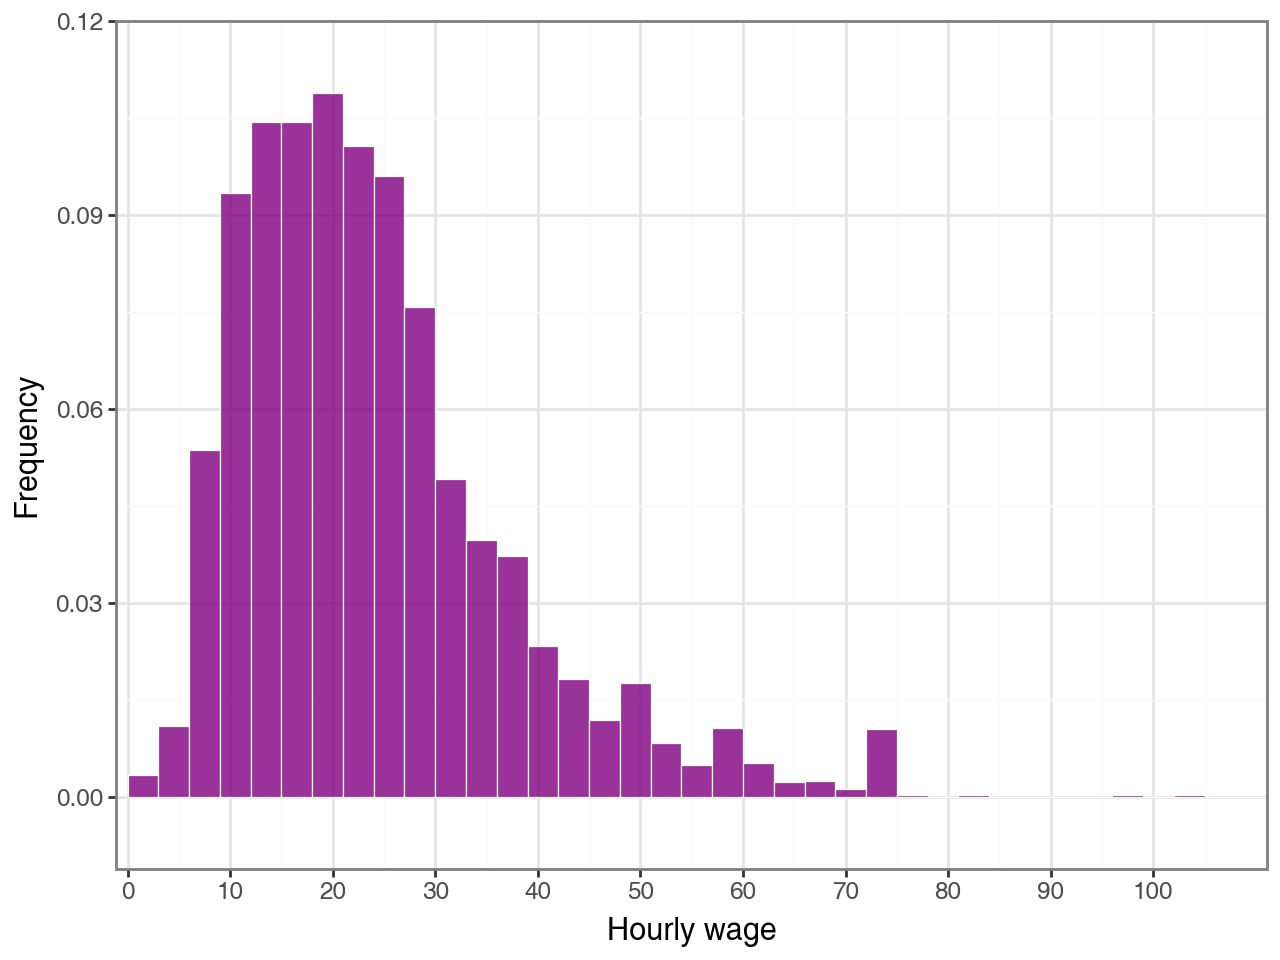

In [745]:
# Hourly wage
(
    ggplot(data_work, aes(x="earn_h"))
    + geom_histogram(
        aes(y="(stat(count))/sum(stat(count))"),
        binwidth=3 ,
        boundary=0,
        color="white",
        fill='purple',
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + coord_cartesian(xlim=(0, 110))
    + labs(x="Hourly wage", y="Frequency")
    + theme_bw()
    + expand_limits(x=0.01, y=0.01)
    + scale_y_continuous(expand=(0.01, 0.01))
    + scale_x_continuous(expand=(0.01, 0.01), breaks=np.arange(0, 110, 10))
)

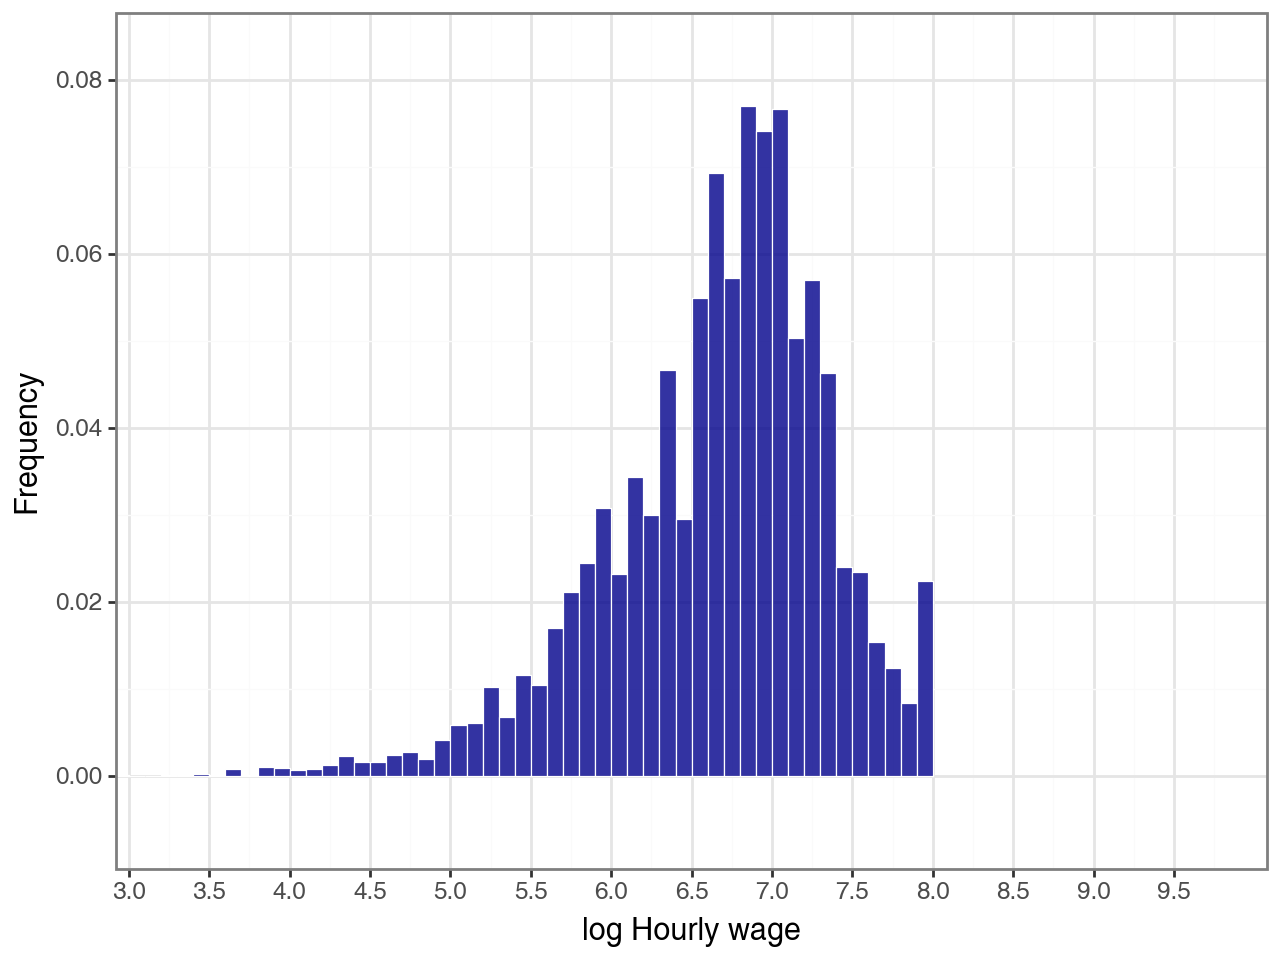

In [746]:
# Log hourly wage
(
    ggplot(data_work, aes(x="ln_earn_h"))
    + geom_histogram(
        aes(y="(stat(count))/sum(stat(count))"),
        binwidth= 0.1,
        boundary=0,
        color="white",
        fill='darkblue',
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + coord_cartesian(xlim=(3, 10))
    + labs(x="log Hourly wage", y="Frequency")
    + theme_bw()
    + expand_limits(x=0.01, y=0.01)
    + scale_y_continuous(expand=(0.01, 0.01))
    + scale_x_continuous(expand=(0.01, 0.01), breaks=np.arange(0, 10, 0.5))
)

In [747]:
# Filter for additional outliers: 
# Check 99 percentile
data_work["earn_h"].quantile(0.99)

# filter accordingly
data_work = data_work.loc[data_work['earn_h'] < 73]

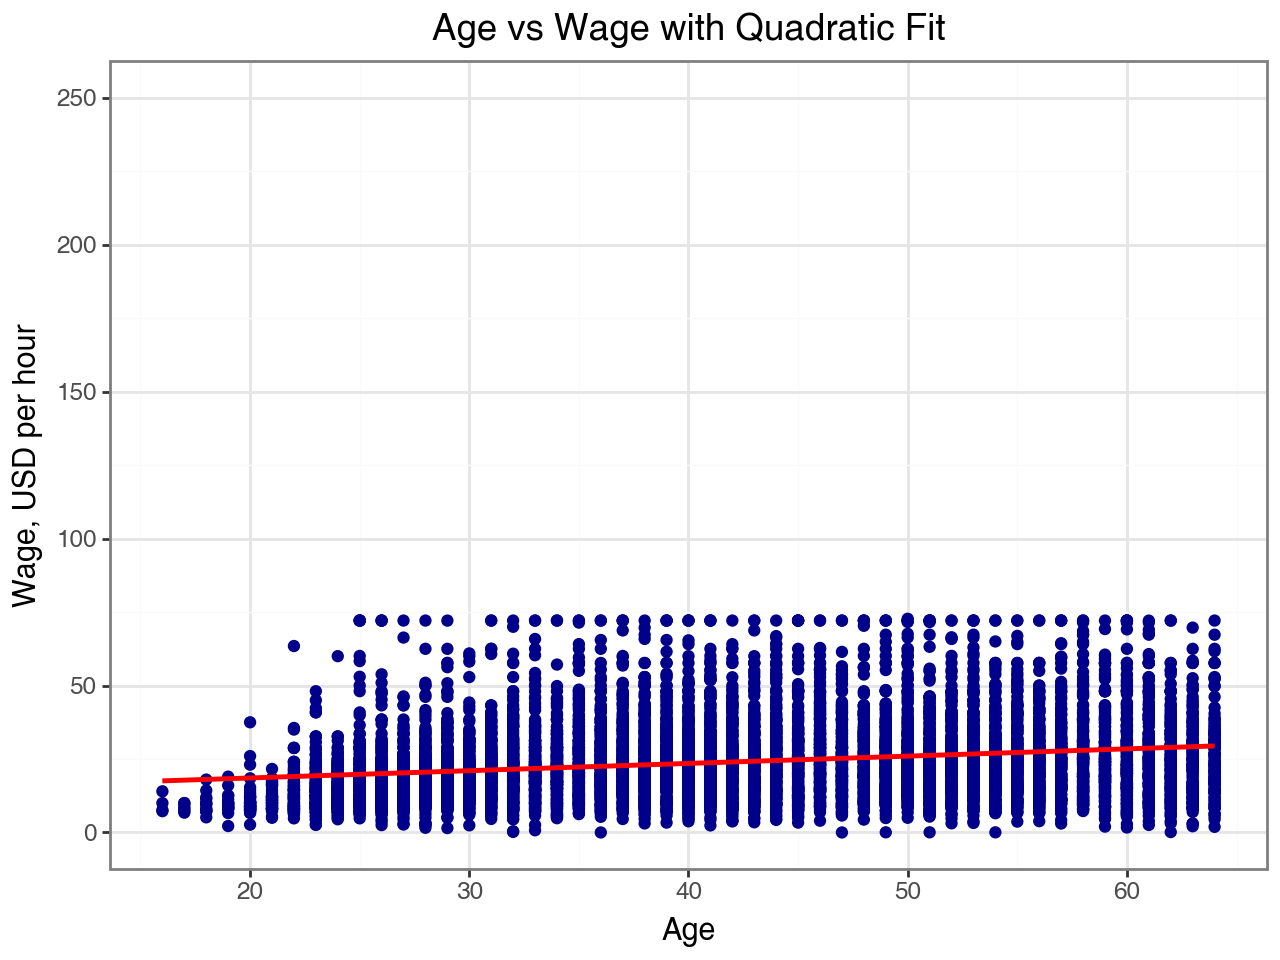

In [748]:
# Check3: which polynomial degree for age and education?

# Age
(  ggplot(data_work, pn.aes(x='age', y='earn_h'))  
    + coord_cartesian(ylim=(0, 250))
    + pn.geom_point(color='darkblue')  # Scatter plot for points
    + pn.stat_smooth(method='lm', formula='y ~ poly(x, 1)', color='red')  # Quadratic fit line - try also higher degrees 
    + pn.labs(title="Age vs Wage with Quadratic Fit", x='Age', y='Wage, USD per hour')  # Title and axis labels
    + theme_bw()
)

# doesn't look like a quadratic relationship - keep linear


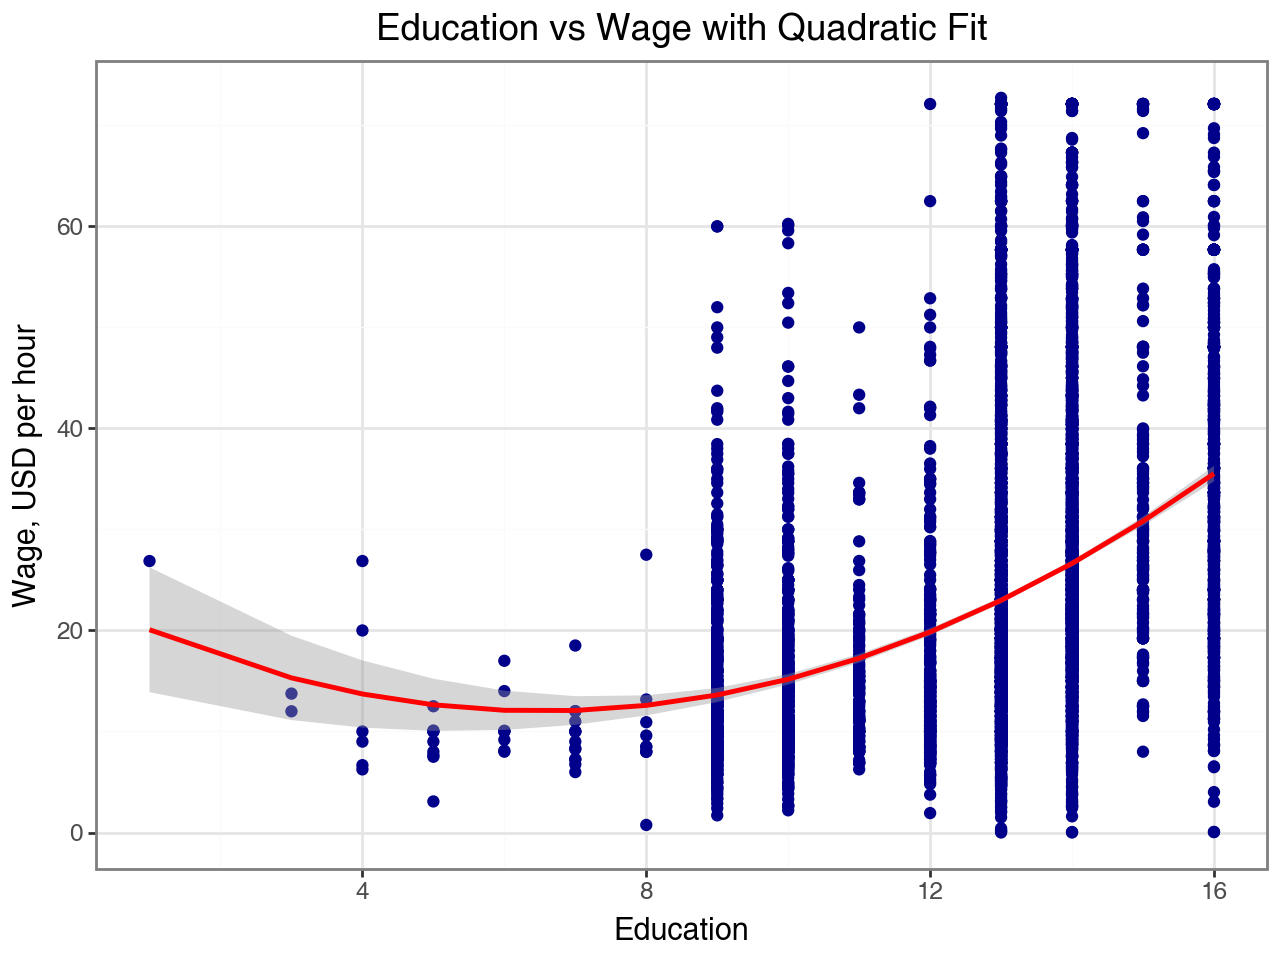

In [749]:
# Education

(  ggplot(data_work, pn.aes(x='edu_c', y='earn_h'))  
    + pn.geom_point(color='darkblue')  
    + pn.stat_smooth(method='lm', formula='y ~ poly(x, 2)', color='red')  # quadratic fit line
    + pn.labs(title="Education vs Wage with Quadratic Fit", x='Education', y='Wage, USD per hour')  
    + theme_bw()
)

# quadratic drift at incresing value of eduction, keep the quadratic function

# Model Prediction

In [750]:
# Linear regression
# note: sex reference category is Male

# recode class as job_class (not recognized by the formula otherwise)
data_work = data_work.rename(columns={"class": "job_class"})

# Model 1: Linear regression on basic Demographics 
model1 = "earn_h ~ age + sex + edu_c + ownchild + married_d + C(race_class) + native_us"

# Models 2-4: Multiple linear regressions
# Model 2: Full demographics: add education (quadratic) + interaction married * sex
model2 = "earn_h ~  age + sex + edu_c + edu2_c + ownchild + married_d + married_d * sex "

# Model 3: add job characteristics - i.e. class, industry (i.e. type of school), presence of union , part time job
model3 = "earn_h ~ age + sex + edu_c + edu2_c + ownchild + married_d + married_d * sex + parttime_d + unionmme +  C(ind02) +C(job_class, Treatment(reference='Government - Local'))"

# Model 4: add categorical on the state of residence (to control for spatial heterogeneity due to country-specific legislations) 
model4 = "earn_h ~ age + sex + edu_c + edu2_c + ownchild + married_d + married_d * sex + parttime_d + unionmme + C(ind02) + C(job_class, Treatment(reference='Government - Local')) + C(stfips) "

model_equations = [model1, model2, model3, model4]

regs = []
for equation in model_equations:
    regs.append(smf.ols(equation, data_work).fit(cov_type="HC1"))


### Table 1 - Full regression results

In [751]:
# complete regression results
from stargazer import stargazer
stargazer.Stargazer(regs[:4])


### Table 2 - Regression results (focus on Gender and Education)

In [752]:
from stargazer import stargazer

stargazer = stargazer.Stargazer(regs[:4])
stargazer.covariate_order(["sex"])
stargazer.add_line("Basic demographics: age, gender, marital status", ["Yes", "Yes", "Yes", "Yes"])
stargazer.add_line("Full demo V1: Ethinic background", ["Yes", "", "", ""])
stargazer.add_line("Full demo V2: Education^2 & married-gender interact. ", ["", "Yes", "Yes", "Yes"])
stargazer.add_line("Job characteristics", ["", "", "Yes", "Yes"])
stargazer.add_line("State of residence", ["", "", "", "Yes"])
stargazer

In [753]:
# export table in html
table_html = stargazer.render_html()
with open("regression_results.html", "w") as f:
    f.write(table_html)


# Cross validation

In [754]:
n_fold = 4
cv_list = []
for equation in model_equations:
    cv_list.append(ols_crossvalidator(equation, data_work, n_fold, average_rmse=False))

#help(ols_crossvalidator)

## Table 3 - Full sample statistics across regression models

In [755]:
(
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        RMSE=lambda x: x["RMSE"].astype(int),
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
        Model=["Model " + str(i + 1) for i in range(len(model_equations))],
        Nvars=[9,7,15, 65],
    )
    .filter(["Model", "Nvars", "Coefficients", "R-squared", "RMSE", "BIC"])
    .set_index("Model")
)

,Nvars,Coefficients,R-squared,RMSE,BIC
Model,,,,,
Model 1,9,10,0.19,11,67581
Model 2,7,8,0.20,11,67506
Model 3,15,16,0.22,11,67301
Model 4,65,66,0.25,11,67388


## Table 4 - Cross-Validation Results

In [756]:
pd.DataFrame(
    [cv["Test RMSE"] for cv in cv_list],
    index=["Model " + str(i + 1) for i in range(len(cv_list))],
    columns=["Fold" + str(i + 1) for i in range(len(cv_list[0]["Test RMSE"]))],
).assign(Average=lambda x: x.mean(axis=1)).T.round(0).astype(int)

,Model 1,Model 2,Model 3,Model 4
Fold1,11,11,11,11
Fold2,12,12,11,11
Fold3,12,12,12,12
Fold4,12,12,12,12
Average,12,12,12,11
